Raw Audio Segment (First 16 samples): [-0.0961   -0.10025  -0.093964 -0.074951 -0.048065 -0.021393 -0.001648
  0.012543  0.028961  0.043976  0.050781  0.0466    0.028687  0.005554
 -0.017059 -0.035309]
Normalized Audio Segment (First 16 samples): [-0.319242 -0.333029 -0.312145 -0.248986 -0.159672 -0.071067 -0.005474
  0.041667  0.096208  0.146087  0.168694  0.154805  0.095296  0.018451
 -0.056671 -0.117295]
Windowed Audio Segment (Frame 1, First 16 samples): [-0.       -0.000001 -0.000003 -0.000005 -0.000006 -0.000004 -0.
  0.000005  0.000015  0.000028  0.00004   0.000044  0.000032  0.000007
 -0.000026 -0.000062]
FFT Result (Frame 1, First 8 pairs): [-0.438533+0.j        0.242588+0.030829j -0.007976+0.087276j
 -0.058968-0.057344j  0.216698-0.003804j -0.363999+0.101228j
  0.051358-0.06361j  -0.024358-0.397915j]
Power Spectrum (Frame 1, First 8 values): [0.192311 0.059799 0.007681 0.006766 0.046973 0.142743 0.006684 0.15893 ]
First Time Frame of Mel Spectrogram (Ampl): [  126.   7678.4  

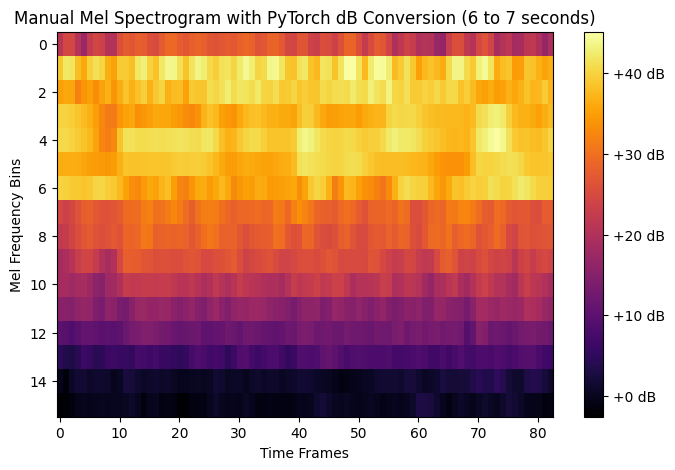

In [16]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import torch
import torchaudio.functional as F
import torchaudio.transforms as T

# Constants
SAMPLE_RATE = 44100
DURATION = 1.0
N_MELS = 16
HOP_LENGTH = 512
N_FFT = 2048
SKIP_SAMPLES = 6 * SAMPLE_RATE

def generate_mel_spect(audio_path):
    y, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    segment = y[SKIP_SAMPLES:SKIP_SAMPLES + int(DURATION * SAMPLE_RATE)]
    
    np.set_printoptions(precision=6, suppress=True)
    print("Raw Audio Segment (First 16 samples):", segment[:16])

    # Normalize segment
    segment /= np.max(np.abs(segment)) if np.max(np.abs(segment)) > 0 else segment

    # Apply Hann window (as in MelSpectrogram transform)
    window = np.hanning(N_FFT)

    # Generate PyTorch Mel filterbank (matching MelSpectrogram behavior)
    mel_filters = F.melscale_fbanks(
        n_freqs=N_FFT // 2 + 1,
        f_min=0,
        f_max=SAMPLE_RATE / 2,
        n_mels=N_MELS,
        sample_rate=SAMPLE_RATE,
        norm=None,  
        mel_scale="htk",
    ).T  # Transpose to match (n_mels, n_freq_bins)

    N_FRAMES = (len(segment) - N_FFT) // HOP_LENGTH + 1
    mel_spectrogram_manual = np.zeros((N_MELS, N_FRAMES))

    for t in range(N_FRAMES):
        frame_start, frame_end = t * HOP_LENGTH, t * HOP_LENGTH + N_FFT
        frame = segment[frame_start:frame_end] if frame_end <= len(segment) else np.pad(segment[frame_start:], (0, frame_end - len(segment)))
        frame_windowed = frame * window  # Apply Hann window to the frame

        if t == 0:
            print("Normalized Audio Segment (First 16 samples):", segment[:16])
            print(f"Windowed Audio Segment (Frame {t+1}, First 16 samples):", frame_windowed[:16])

        fft_result = np.fft.rfft(frame_windowed, n=N_FFT)
        
        if t == 0:
            print(f"FFT Result (Frame {t+1}, First 8 pairs):", fft_result[:8])

        power_spectrum = np.abs(fft_result) ** 2
        
        if t == 0:
            print(f"Power Spectrum (Frame {t+1}, First 8 values):", power_spectrum[:8])

        # Convert to torch tensor and apply PyTorch filterbank
        power_spectrum_torch = torch.tensor(power_spectrum[:N_FFT // 2 + 1]).float()
        mel_spectrogram_manual[:, t] = torch.matmul(mel_filters, power_spectrum_torch).numpy()

    mel_spectrogram_db = T.AmplitudeToDB()(torch.tensor(mel_spectrogram_manual).float()).cpu().numpy()

    np.set_printoptions(precision=1, suppress=True)
    print("First Time Frame of Mel Spectrogram (Ampl):", np.round(mel_spectrogram_manual[:, 0], 1))
    print("First Time Frame of Mel Spectrogram (indB):", np.round(mel_spectrogram_db[:, 0], 2))

    return mel_spectrogram_db

# Generate and plot mel spectrogram
audio_path = 'mix.wav'
mel_spect = generate_mel_spect(audio_path)

plt.figure(figsize=(8, 5))
plt.imshow(mel_spect, aspect='auto', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Manual Mel Spectrogram with PyTorch dB Conversion (6 to 7 seconds)')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')
plt.show()


In [17]:
import torch
import torchaudio.functional as F
import numpy as np

# Constants
SAMPLE_RATE = 44100
N_FFT = 2048
N_MELS = 16
F_MIN = 0  # Minimum frequency
F_MAX = SAMPLE_RATE / 2  # Nyquist frequency
N_FREQ_BINS = N_FFT // 2 + 1  # Number of frequency bins

# Compute Mel filterbank using PyTorch
mel_filters = F.melscale_fbanks(
    n_freqs=N_FREQ_BINS,
    f_min=F_MIN,
    f_max=F_MAX,
    n_mels=N_MELS,
    sample_rate=SAMPLE_RATE,
    mel_scale="htk",  # Can be 'htk' or 'slaney' (Librosa default is 'slaney')
).T  # Transpose to match expected (n_mels, n_freq_bins) format

# Convert to NumPy for saving
mel_filters = mel_filters.numpy()

# Save filterbank in C array format
with open("mel_filterbank.h", "w") as f:
    f.write("#ifndef MEL_FILTERBANK_H\n#define MEL_FILTERBANK_H\n\n")
    f.write(f"#define SAMPLE_RATE {SAMPLE_RATE}\n")
    f.write(f"#define N_FFT {N_FFT}\n")
    f.write(f"#define N_MELS {N_MELS}\n")
    f.write(f"#define N_FREQ_BINS {N_FREQ_BINS}\n\n")  # Useful for indexing

    f.write("static const float mel_filterbank[N_MELS][N_FREQ_BINS] = {\n")
    for row in mel_filters:
        f.write("    {" + ", ".join(f"{val:.8f}f" for val in row) + "},\n")
    f.write("};\n\n")
    f.write("#endif // MEL_FILTERBANK_H\n")

# Save specifications
with open("mel_specs.txt", "w") as f:
    f.write(f"SAMPLE_RATE: {SAMPLE_RATE}\n")
    f.write(f"N_FFT: {N_FFT}\n")
    f.write(f"N_MELS: {N_MELS}\n")
    f.write(f"N_FREQ_BINS: {N_FREQ_BINS}\n")
    f.write(f"F_MIN: {F_MIN}\n")
    f.write(f"F_MAX: {F_MAX}\n")
    f.write(f"MEL_SCALE: htk (default)\n")


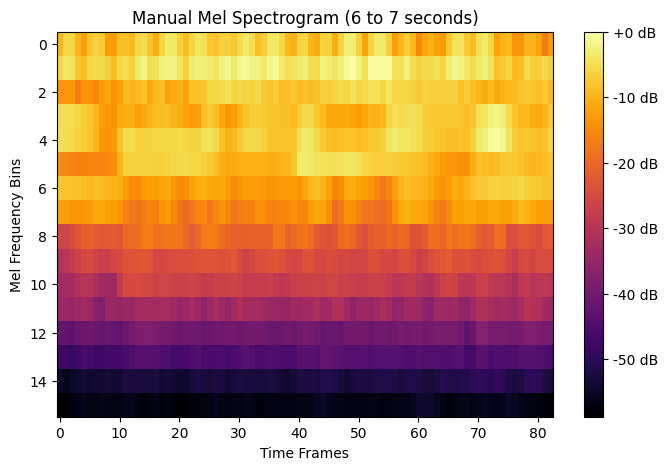

In [28]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Constants
SAMPLE_RATE = 44100
DURATION = 1.0  # Segment duration (1 second)
N_MELS = 16  # Number of mel bands
HOP_LENGTH = 512  # Hop length for the mel spectrogram
N_FFT = 2048  # FFT size
SKIP_SAMPLES = 6 * SAMPLE_RATE  # Skip 6 seconds of audio

def mel_filterbank(sr, n_fft, n_mels):
    """Generate Mel filterbank"""
    return librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, norm=1)

def generate_mel_spect(audio_path):
    # Load audio
    y, _ = librosa.load(audio_path, sr=SAMPLE_RATE)

    # Slice the audio to start from 6 seconds and take 1 second segment
    start_sample = SKIP_SAMPLES
    end_sample = start_sample + int(DURATION * SAMPLE_RATE)
    segment = y[start_sample:end_sample]

    # Normalize the segment to [-1, 1]
    segment = segment / np.max(np.abs(segment)) if np.max(np.abs(segment)) > 0 else segment

    # Get Mel filterbank
    mel_filters = mel_filterbank(SAMPLE_RATE, N_FFT, N_MELS)

    # Compute STFT frames manually
    N_FRAMES = (len(segment) - N_FFT) // HOP_LENGTH + 1
    mel_spectrogram_manual = np.zeros((N_MELS, N_FRAMES))  # Shape: (mel bins, time frames)

    for t in range(N_FRAMES):
        frame_start = t * HOP_LENGTH
        frame_end = frame_start + N_FFT

        # Zero-pad if we exceed signal length
        if frame_end > len(segment):
            frame = np.pad(segment[frame_start:], (0, frame_end - len(segment)))
        else:
            frame = segment[frame_start:frame_end]

        # Apply Hann window
        hann_window = np.hanning(N_FFT)
        frame_windowed = frame * hann_window

        # Compute FFT
        fft_result = np.fft.rfft(frame_windowed, n=N_FFT)

        # Compute Power Spectrum
        power_spectrum = np.abs(fft_result) ** 2

        # Apply Mel filterbank
        mel_spectrogram_manual[:, t] = np.dot(mel_filters, power_spectrum[:N_FFT // 2 + 1])

    # Convert to dB
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram_manual, ref=np.max)

    return mel_spectrogram_db

# Generate mel spectrogram from the audio file (from 6 to 7 seconds)
audio_path = 'mix.wav'  # Path to the audio file
mel_spect = generate_mel_spect(audio_path)

# Plot the mel spectrogram
plt.figure(figsize=(8, 5))
plt.imshow(mel_spect, aspect='auto', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Manual Mel Spectrogram (6 to 7 seconds)')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')
plt.show()
